## Mushroom Pokédex Project
Author: Alexander Mars

This notebook continues on from '1-mush-obs-EDA.ipynb' where I explored and cleaned the csv data. This notebook will download and prepare the image data for use with a classificaiton model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import * # for ease of use
import os, math, numpy, pandas as pd
import seaborn as sns

### Loading the Data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# google drive datapath
#datapath = Path('/content/drive/MyDrive/Colab Notebooks/mushroom-proj/data')
# CWD datapath 
datapath = Path.cwd() / Path('data')
datapath

Path('/notebooks/storage/mushroom_obs/data')

The below CSVs were generated using the mush-obs-filtering notebook from the raw CSVs provided by mushroomobserver

In [5]:
species = pd.read_csv(datapath/'species_conf2_taxons1-4.csv')
species_obs = pd.read_csv(datapath/'obs_conf2_taxons1-4.csv')
images = pd.read_csv(datapath/'images_observations.csv')

### Most Commonly Observed Mushrooms

Before downloading images, I want to know how many images are associated with each taxon id. If there are only a handful of images for a particular taxon, we won't want to include it as there will be too few data points in the training set for this class. 

Now getting the top 100 or top 1000 frequently observed obs is trivial using pandas

In [6]:
all_taxons = species_obs['taxon_id'].tolist()
top_100_taxons = species_obs['taxon_id'].value_counts()[:100].index.tolist()
top_1000_taxons = species_obs['taxon_id'].value_counts()[:1000].index.tolist()
top_100_taxons

['s8935.0',
 's4152.0',
 's8882.0',
 's2852.0',
 's2669.0',
 's8924.0',
 's253.0',
 's2818.0',
 's8869.0',
 's4157.0',
 's7059.0',
 's2883.0',
 's8908.0',
 's2735.0',
 's7118.0',
 's5848.0',
 's3614.0',
 's6080.0',
 's537.0',
 's6024.0',
 's2523.0',
 's7649.0',
 's3868.0',
 's6107.0',
 'n100',
 's2663.0',
 's6913.0',
 's6768.0',
 's174.0',
 's2814.0',
 's57.0',
 's8982.0',
 's2681.0',
 's508.0',
 's132.0',
 'n271',
 's2536.0',
 's496.0',
 'n139',
 's6563.0',
 's8870.0',
 's6324.0',
 's2591.0',
 's2853.0',
 's5053.0',
 's2854.0',
 's2650.0',
 's5575.0',
 's7558.0',
 'n53',
 's4073.0',
 's4455.0',
 's2876.0',
 'n330',
 's2945.0',
 's2994.0',
 's2658.0',
 's6222.0',
 's8986.0',
 's4709.0',
 's6036.0',
 's4176.0',
 'n44785',
 's6068.0',
 's3197.0',
 'n958',
 's620.0',
 's641.0',
 's605.0',
 's2592.0',
 's3205.0',
 's2961.0',
 's134.0',
 'n2710',
 's4112.0',
 's175.0',
 's3854.0',
 's3883.0',
 's8905.0',
 'n362',
 's4616.0',
 's570.0',
 's59.0',
 's580.0',
 'n383',
 's2654.0',
 's2510.0',
 

In [7]:
len(all_taxons)

114072

In [8]:
# Most observed
len(species_obs[species_obs.taxon_id=='s8935.0'].index)

907

In [9]:
species[species.synonym_id==8935.0].iloc[0]['text_name']

'Amanita muscaria'

No surprises there, the most commonly observed mushroom on mushroom observer (species level and below) is Amanita muscaria! 

In [10]:
# 100th most observed
len(species_obs[species_obs.taxon_id=='s3155.0'].index)

165

Now I'm going to see how many images are associated with each taxon_id

In [11]:
images.head(10)

,image_id,observation_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
5,6,6
6,7,7
7,8,8
8,9,9
9,10,9


Each image is associated with an observation, and we can see that multiple images may be linked to an observation

In [ ]:
def make_taxon_lists(top_taxons):
    taxon_images = {}
    images_per_taxon = {}
    for t_id in top_taxons:
        t_obs = list(species_obs.loc[species_obs.taxon_id==t_id,'id'])
        taxon_images[t_id] = list(images.loc[images.observation_id.isin(t_obs),'image_id'])
        images_per_taxon[t_id] = len(images.loc[images.observation_id.isin(t_obs)].index)
    return taxon_images, images_per_taxon
top_100_images, images_per_100 = make_taxon_lists(top_100_taxons)
top_1000_images, images_per_1000 = make_taxon_lists(top_1000_taxons)
all_images, images_per_all = make_taxon_lists(all_taxons)

<AxesSubplot:ylabel='Count'>

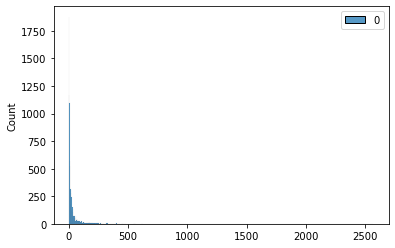

In [13]:
sns.histplot(images_per_all.values())

<AxesSubplot:ylabel='Count'>

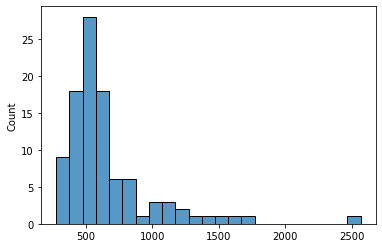

In [14]:
sns.histplot(images_per_100)

<AxesSubplot:ylabel='Count'>

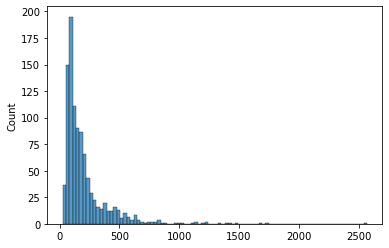

In [15]:
sns.histplot(images_per_1000)

In [16]:
print(min(images_per_1000.values()))
print(min(images_per_100.values()))

274

In [17]:
max(images_per_1000.values())

2568

In [18]:
sum(images_per_100.values())/100

658.38

In [19]:
sum(images_per_1000.values())/1000

208.114

In [20]:
# saving the association of taxons to images in a csv as it might be useful later
print(all_)

NameError: name 'all_' is not defined

Ok so we have 66,046 images of mushrooms across the top 100 most commonly observed taxons, and 207,929 images across the top 1000 taxons

### Downloading Images

#### Create an image directory

In [21]:
mushroom_images = Path(datapath/'mushroom-images')

In [33]:
# Run this if you want to remove the mushroom-images folder
#import shutil
#shutil.rmtree(mushroom_images)

In [34]:
os.mkdir(mushroom_images)

#### Creating classes

Now I'm to create classes that will be used to train the model, these classes will serve as folder and file names for their respective images too.

In [35]:
species.head(5)

,Unnamed: 0,id,text_name,deprecated,correct_spelling_id,synonym_id,rank
0,2,3,Xylaria magnoliae,0,NaN,NaN,4
1,5,6,Xerocomus zelleri,1,NaN,505.0,4
2,6,7,Xerocomus subtomentosus,0,NaN,645.0,4
3,8,9,Xerocomus chrysenteron,1,NaN,504.0,4
4,11,12,Verpa bohemica,0,NaN,2545.0,4


In [36]:
# Synonym_id Rank -> String
# Get all the class names for the most commonly observed taxons
def get_class_name(tax_id, r):
    
    def get_class_subf(condition, id_val, r):
        return species[(species[condition]==float(id_val)) & (species['rank']==r)]
    
    if tax_id[0] == 's':
        c = get_class_subf('synonym_id', tax_id[1:], r)
        if not c.empty:
            return c.iloc[0]['text_name'].replace(' ', '-')
        else:
            '-'.join(get_class_name(tax_id,r-1).split()[:2])
    else:
        c = get_class_subf('id', tax_id[1:], r)
        if not c.empty:
            return c.iloc[0]['text_name'].replace(' ', '-')
        else:
            '-'.join(get_class_name(tax_id,r-1).split()[:2])



In this notebook I am going to start with the top 1000 taxons, hence I use the top_1000_taxons list below:

In [37]:
# You can choose how many classes/how many of the top taxons you want to build the classifier around
classes = []
for t_id in top_1000_taxons:
    c = get_class_name(t_id, 4)
    classes.append(c)

In [38]:
# Sanity check that there are no duplicates in this list
# there should not be if the assimilate taxon_ids algorithm worked properly
len(classes) == len(set(classes))

True

In [39]:
classes

['Amanita-muscaria',
 'Trametes-versicolor',
 'Lepista-nuda',
 'Schizophyllum-commune',
 'Coprinus-comatus',
 'Pleurotus-ostreatus',
 'Lycoperdon-perlatum',
 'Galerina-autumnalis',
 'Boletus-edulis',
 'Mixed-collection',
 'Polyporus-squamosus',
 'Phaeolus-schweinitzii',
 'Hypholoma-fasciculare',
 'Amanita-phalloides',
 'Psilocybe-cyanescens',
 'Laetiporus-sulphureus',
 'Lenzites-betulina',
 'Ganoderma-applanatum',
 'Lycoperdon-pyriforme',
 'Mycena-haematopus',
 'Trichaptum-biforme',
 'Hypomyces-lactifluorum',
 'Lycogala-epidendrum',
 'Mycena-leaiana',
 'Pseudohydnum-gelatinosum',
 'Panellus-stipticus',
 'Psilocybe-ovoideocystidiata',
 'Bolbitius-vitellinus',
 'Hericium-erinaceus',
 'Phyllotopsis-nidulans',
 'Chlorophyllum-molybdites',
 'Leratiomyces-ceres',
 'Fuligo-septica',
 'Tapinella-atrotomentosa',
 'Gomphus-floccosus',
 'Flammulina-velutipes',
 'Armillaria-tabescens',
 'Clavicorona-pyxidata',
 'Omphalotus-illudens',
 'Armillaria-mellea',
 'Ceratiomyxa-fruticulosa',
 'Coprinellus-

#### Fetching Image URLs


For each class, I'm going to create a CSV file containing all the image URLs available through mushroomobserver.org

In [40]:
len(classes)

1000

Note the below URL bypasses the servers at mushroom observer and was provided to me by the webmasters. 

In [41]:
base_URL = 'https://images.mushroomobserver.org/320/img_id.jpg'
for i, (t_id, img_ids) in enumerate(top_1000_images.items()):
    os.mkdir(mushroom_images/classes[i])
    filename = classes[i]+'.csv'
    with open(mushroom_images/classes[i]/filename, 'w') as f:
        for img_id in img_ids:
            f.write(base_URL.replace('img_id', str(img_id)))
            f.write('\n')

#### Downloading Images

In [47]:
# Using the FastAI download_images function
for i, mushroom in enumerate(classes):
    filename = classes[i]+'.csv'
    path = mushroom_images/classes[i]/filename
    dest = mushroom_images/classes[i]
    download_images(url_file=path, dest=dest, max_pics=2500)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [51]:
# Using the fast_ai verify_images function
# this will try to open all the images downloaded 
# and delete any that cannot be opened
for i, mushroom in enumerate(classes):
    path = mushroom_images/classes[i]
    images = list(path.rglob('*.jpb'))
    failed = verify_images(images) 
    failed.map(Path.unlink)

I noticed whilst visualising the data batch below that one of the top 1000 taxon-id's collected was linked to a species called 'mixed-collection'. I'm going to remove this folder before continuing as it will likely contribute to error in the model. 

In [52]:
rm = Path('Mixed-collection')
shutil.rmtree(mushroom_images/rm)

We can now see how many images we actually have left:

In [53]:
totalDir = 0
totalFiles = 0
for base, dirs, files in os.walk(mushroom_images):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Abortiporus-biennis
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-arvensis
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-augustus
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-bernardii
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-bisporus
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-bitorquis
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-californicus
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-campestris
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-hondensis
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-moelleri
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Agaricus-placomyces
Searching in :  /Volu

Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Ductifera-pululahuana
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Echinodontium-tinctorium
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Enteridium-lycoperdon
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entoloma-abortivum
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entoloma-conicum
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entoloma-medianox
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entoloma-murraii
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entoloma-salmoneum
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entoloma-serrulatum
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Entonaema-liquescens
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Evernia-prunastri
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Exidia-crenata

Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Nolanea-strictia
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Nolanea-verna
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Oligoporus-fragilis
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Oligoporus-guttulatus
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Omphalotus-illudens
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Omphalotus-olivascens
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Onnia-tomentosa
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Otidea-onotica
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Oudemansiella-radicata
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Oxyporus-populinus
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Pachylepyrium-carbonicola
Searching in :  /Volumes/Alex/mushroom_obs/data/mushroom-images/Panaeolus-antillar

In [ ]:
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Now we have our images in appropriate class folders. We can now design and test some classification models. This will be continued in another notebook.